# Simulator


&emsp;The goal of our work is researching some approaches to solve the problem of maximizing the average number of pages read in multi-page publications. We want to learn how we need to lead the agent through the pages to cause her consuming as much content as possible. Unfortunately we have no special lab or resource to perform field experiments. That's why we need to build a good simulator that will mimic the agents behavior.  
&emsp;The simulator receives from the outside directed graph that represents the structure of the content. Each vertex is a page and an edge from vertex A to vertex B expresses the link between page A and B, i.e. the next page that is presented to the agent after seeing page A may be page B. That is if there is no edge between vertex A and C , C can't be presented to the agent right after A.<br><br>
The core part of this project is imitating the traversal of the agent through the pages. This process is divided into rounds and on each round the following steps occurs:<br>
    &emsp;**1)**  Agent watches some page from the set of pages that we presented to her. In terms of graph abstraction - she is at some vertex of the graph.<br>
    &emsp;**2)** After watching the page, the agent chooses one of three actions: go to the next page, return to the previous page, or stop watching pages and leave.<br>
    &emsp;**3)** If the agent selected the "next" action, the simulator choose the page to present to the agent at the next round. <br>
    &emsp;&emsp; If the agent selected the "back" action, one of the pages she previously watched will be presented at the next round (the exact mechanics will be explained further).<br>
    &emsp;&emsp;If the agent selected the "leave" action, the simulation stops.<br>
    &emsp;**4)** The round finishes, the user is traversed to the node that was chosen on the previous step and  the next round starts.<br><br>

&emsp;Here focus on the first and the second step. We want to imitate the reaction of real Internet user to some piece of content. For example the agent liked the picture (or the sequence of pictures), found it to be interesting and want to see the next one, or the opposite case, when she is bored with the current picture (or sequence of presented pictures) and don't want to keep watching. It's important to mention that the action the user performs is not supposed to be  deterministic, it is more natural to think  of it in terms of probability. If the user liked the page she saw, she is more likely to press next, than after seeing the page that she loved less.  

    

In [1]:
using Pkg

try
    using GraphRecipes
    using SimpleWeightedGraphs
    using StatsPlots
    using LightGraphs
catch  LoadError
    Pkg.add("GraphRecipes")
    Pkg.add("SimpleWeightedGraphs")
    Pkg.add("StatsPlots")
    Pkg.add("LightGraphs")
    using StatsPlots
    using LightGraphs
    using GraphRecipes
    using SimpleWeightedGraphs
end;

### Simple version 

### Data structures and types

&emsp; In all versions of the simulator there will always be 3 entities: 1) The page with content - it is represented by node in graph 2) The graph that imposes constrains on the possible orders of  presenting the pages to the user 3)  The user that visits the pages .<br><br>

Here we present very simple implementation of the above concepts:
&emsp;Directed graph of the type *Graph1* describes possible pages links. Vertexes of the graph of type *Node1* represent one single page that the agent is supposed to see. The nodes has no special mechanism to describe the content of the associated page, and they differs only by id.<br>
<br>
&emsp; *User1* type represents  one agent, that traverse the pages of content. The core part of it is a *choiseFunction* attribute. It is a function that defines the behavior of the agent with respect to each page (whether she leaves, proceeds or goes back). It should be assigned when the user is created.

In [2]:
@enum UserAction  goBack goNext leave

struct Node1 
    id :: String
    NameInInput :: Any   
end



struct Graph1 
    graph :: SimpleWeightedDiGraph
    nodes :: Dict{Int64, Node1}
end



struct User1 
   id :: String 
   ActionChoiseFunction  :: Any
    end;



In [3]:
# Auxiliary variables for statistics
initialized = true
visitMatrix = nothing 
visitVector = nothing

pagesStatistics = nothing
pathesLength = nothing


totalPagesSeen = -1
averagePagesSeen = -1 

pages_number = 6

mutable struct PageStat
    pageNumber :: Int64
    totalSeen :: Int64
    NextBackLeave
end;


### Auxiliary functions
Here we define simple auxiliary functions

In [4]:
# id_generator , get_node , printPath , getNeibhors

# Create a counter , used to produce unique ids
function id_generator()
    id = 0 
    return ()-> id = id + 1
end

nodeIdGenerator = id_generator()    # Nodes id generator
userIdGenerator = id_generator()    # Users id generator



# Return Node that corresponds to some name (that was given in input source , typicaly number)

function get_node(NameInInput, graph:: Graph1)
   return  graph.nodes[NameInInput]
end



# Given array of nodes , print their names devided by "=>"
# It is supposed to print the users path in the graph
function printPath(path :: Array{Node1,1})
    string_path = join(map(node-> node.NameInInput,path),"=>")
    println("Pages the user visited are : $string_path")
    
end

# Given node and graph , return node's neighbors
function getNeibhors(node :: Int64, graph :: Graph1) 
    return neighbors(graph.graph,node)
end

function getNeibhors(node :: Node1, graph :: Graph1) 
    return neighbors(graph.graph, node.NameInInput)
end


function initialize_statistics(nodes_number, graph)
    actions_number = length(instances(UserAction))
    global visitVector = zeros(nodes_number)
    global visitMatrix = zeros(nodes_number,nodes_number)
    for (a,b) in graph
        global visitMatrix[a,b] = 1
        global visitMatrix[b,a] = 1
    end

    global pagesStatistics = Dict(id=>PageStat(id,0,zeros(actions_number)) for id in 1:nodes_number)
    global pathesLength = Int64[]
end  
;



### Producing the graph 

&emsp;The graph represents the structure of the content. Page B can be shown after page A only if there is edge (A,B) in the graph. It actually imposes constrains on the order in which pages can be shown to the user. <br>
Two extreme cases are possible : each node has outgoing and ingoing edges from/to all nodes -  all possible permutations are allowed. Or the line when each node has only one succedent - there is only one possible order.
<br>
The graph actually is not part of this simulator, it is used by an external algorithm that provides next node to the agent via special interface function (currently getNextNode). We need it here only to run the simulation.
 

The function below produces the simplest variant of the graph of type Graph1 from array of pairs of numbers. It doesn't have any distinctions between the nodes, all the pages are considered the same. It provides only the content structure - the edges between the nodes. 

In [5]:
function createGraph(num_of_vertices :: Int64, simple_tuples :: Array{Tuple{Int64,Int64},1})
    
    node_dict = Dict()
    matrix = zeros(num_of_vertices, num_of_vertices)


    create_new_node = (NameInInput) -> 
                        (()-> (id = string(nodeIdGenerator()); Node1(id,NameInInput)))
    
    for (n1,n2) in simple_tuples
        
        get!(create_new_node(n1),node_dict,n1)
        
        get!(create_new_node(n2),node_dict,n2)

                
        matrix[n1,n2] = 1
         

    end


    graph = Graph1(SimpleWeightedDiGraph(matrix),node_dict)

  return graph
    end;

### Main interface functions

&emsp;The following functions are actually the most important parts of the simulator. The first one defines agent's behavior : which action will be chosen by the agent after watching some particular page (visiting some particular node ). <br>
&emsp;The second function defines which new page will be presented to the agent if she decided to proceed. It will connect the simulator to some external algorithm that will attempt to maximize the number of pages visited.



The functions below are simple implementations:<br>1) In order to choose the next action the inner function of the agent is called <br>2)The next page to show to the user is selected uniformly among neighbors of the current page in the graph. 

In [6]:



function chooseNextAction(user :: User1, node :: Node1) :: UserAction
    user.ActionChoiseFunction(node)
end



function getNextNode(graph :: Graph1, path :: Array{Node1,1})
    currentNode = path[end]
    neighbors = getNeibhors(currentNode,graph)
    if length(neighbors) == 0
        return currentNode
    else 
        return graph.nodes[rand(neighbors)]
    end
    
end;


## Main function 

&emsp;In *performWalk* function the simulation is executed for one agent. Given initial node and content graph, the following function simulates agent's traversal in the set of pages. It assumes that the agent can make 3 actions: 1) Press "next" -- proceed to the next page. 2) Press "back" - go back to the previous page 3) Leave the pages -- it is always the last action in the simulation for the current agent.<br>
In response to each action the current state of the simulator is updated , and the information about user's traversals is collected. <br>
There are two important records here : path and current node . <br> <br>
&emsp;1) **nodesVisited** -- list of unique nodes that were visited by the agent sorted by time they were revealed (by round index).<br>
Walking back and forth is allowed only along the *nodesVisited* list, it happens when the agent presses next and back. When the agent is at the last node ( nodesVisited\[end\] ) and press "next", she traverses to the new node that is returned by *getNextNode* function. <br> 
&emsp;2) **current node** -- the node the agent is currently at i.e the page the user watches now. <br><br>
&emsp;Example: at the beginning the path contains only the initial node N1 and the current node is also N1. Than the user presses "next" and the new node N2 is provided by *getNextNode*, the *nodesVisited* list is (N1,N2) and current node is N2. Than the user presses "back" , the *nodesVisited* remains the same and current node turns equal to N1 . Than the user presses "next" and the state turns to be *nodesVisited* =(N1,N2) current node = N2 .....

In [7]:


function performWalk(user :: User1, graph :: Graph1, initialNode :: Node1)
    
    currentNode = initialNode
    path = Node1[currentNode]
    nodesVisited = Node1[currentNode]
    actions = UserAction[]
    
    

    while true
              
       nextAction = chooseNextAction(user, currentNode)
       push!(actions,nextAction)
       # The agent is somewhere on previous pages that he visited and press next
        if nextAction == goBack && length(nodesVisited) > 1
            
            pop!(nodesVisited)
            currentNode = nodesVisited[end]
            push!(path,currentNode)
            
        # The agent is on the last page that he visited and press next
        elseif nextAction == goNext 
            
            currentNode = getNextNode(graph,path)
            
            # The same node returned as next node - there is no neighbors for the current node
            if path[end] == currentNode
                break
            end
            push!(nodesVisited,currentNode)
            push!(path,currentNode)
            
        # The agent press leave
        else
            
            break
        # Unexpected combination of conditions
        end
        
    end

    return Dict("path" => path, "actions" => actions)
end
;





In [8]:
# Fill up the appropriate statistics about the traversal of one user 

function processUserStat(results)

    path = results["path"]
    actions = results["actions"]

    get_node_id = (i) -> path[i].NameInInput
    node1_id = get_node_id(1)

    @assert length(path)==length(actions)
    global pathesLength
    push!(pathesLength,length(path) - 1)

    for i in 1:(length(path) - 1)
        node2_id = get_node_id(i + 1)

        global visitVector[node1_id] += 1
        global visitMatrix[node1_id,node2_id] += 1
        action = actions[i]
        page_stat = pagesStatistics[node1_id]
        
        page_stat.totalSeen += 1
        page_stat.NextBackLeave[Int(action)+1] += 1
        node1_id = node2_id 
        
    end
    page_stat = pagesStatistics[node1_id]
    action = actions[end]
    page_stat.totalSeen += 1
    page_stat.NextBackLeave[Int(action)+1] += 1


end



vert_edge_weights_func = x -> sqrt(x/10)
edge_weights_func = (a,b,w) -> visitMatrix[a,b] |> vert_edge_weights_func;


## The example of run 

1. ***Define agent's function for selecting the next action : simple uniform random selection***
+ Creating the user with this selection function
+ Creating a simple graph 
+ Getting the initial node object
+ Initializing statistics for graphic representation
+ ***Perform simulation*** with the same agent several times, store statistics and print the agents path 
+ Visualize the result of run (next section)

In [9]:
# 1.
chooseNextAction1 = x -> rand(instances(UserAction))

# 2.
user = User1("1",chooseNextAction1)

# 3.
graph_arr = [(1,2),(2,3),(1,3),(3,4),(4,5),(5,6)]
graph = createGraph(6,graph_arr)

# 4.
initial_node = get_node(1,graph)

# 5.
initialize_statistics(6,graph_arr);

In [10]:
# 6.
for _ in 1:200
    result = performWalk(user,graph,initial_node)
    processUserStat(result)
    
#     println(visitMatrix)
#     println(visitVector)
#     println(pagesStatistics)
#     println(pathesLength)
#     printPath(result["path"])
#     println()
end;

### Run summary 


In [11]:
#
global pathesLength
totalPagesSeen = sum(pathesLength)
averagePagesSeen = totalPagesSeen/length(pathesLength)
println("====================================================================")
println("Total number of pages seen: $(totalPagesSeen + length(pathesLength))")
println("Average path length is: $averagePagesSeen")
println("====================================================================")

Total number of pages seen: 362
Average path length is: 0.81


#### Distribution of number on traversals made by one user ( The length of the path )
How many times each user passed through the pages from the set ( pressed "back" and "next" - except "back" at the initial page )

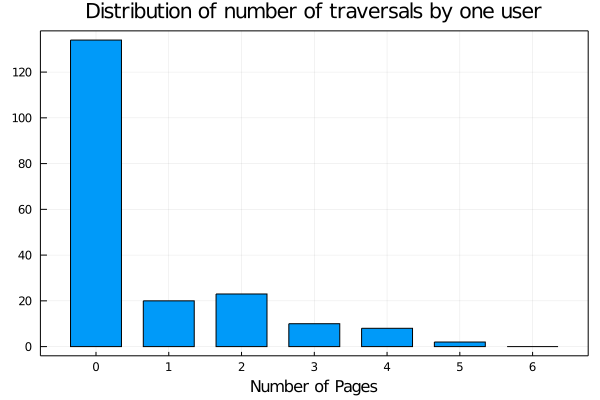

In [12]:
#
pathes_length = [count((x)-> x==len,pathesLength) for len in 0:pages_number]
groupedbar(0:pages_number,
            reshape(pathes_length,length(pathes_length),1),
            bar_position = :stack,
            bar_width=0.7,
            title="Distribution of number of traversals by one user",
            xlabel="Number of Pages",
            leg=false,
            framestyle=:box)



### Distribution of actions per page and "success rate" - the fraction of "press next" actions from the total number of actions  per page
The first figure shows the relative distribution of different actions per page.<br>
The second figure shows the rate of "press next" actions, it can be good indicator for the attractivity of the page for users .

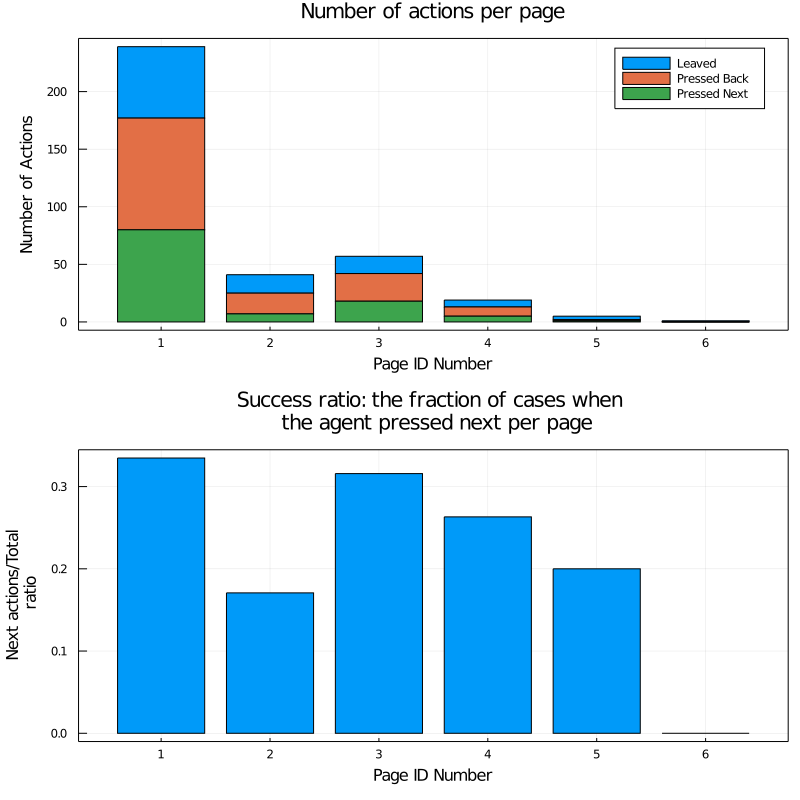

In [13]:
# 
hist_data = zeros(pages_number, 3)
success_rate = zeros(pages_number)

for (id,stat) in pagesStatistics
    
    hist_data[id,1] = stat.NextBackLeave[1]
    hist_data[id,2] = stat.NextBackLeave[2]
    hist_data[id,3] = stat.NextBackLeave[3]
    if stat.totalSeen > 0
        success_rate[id] =  stat.NextBackLeave[2] / stat.totalSeen 
    end
end

pagesStatistics

success_rate
g= groupedbar(hist_data,bar_position = :stack,
                    xlabel="Page ID Number",
                    ylabel="Number of Actions",
                    title="Number of actions per page",
                    framestyle=:box,
                    group=repeat(["Pressed Back","Pressed Next","Leaved"],inner=pages_number))


g1 = groupedbar(reshape(success_rate,length(success_rate),1),
                    xlabel="Page ID Number",
                    ylabel=" Next actions/Total \n ratio",
                    title="Success ratio: the fraction of cases when \n the agent pressed next per page",
                    framestyle=:box,
                    leg=false)


plot(g,g1,size=(800,800),layout=(2,1))

### Statistical representation on the graph
After running the simulation on set of agents, we want to visualize the information about agents activity on the initial graph. Two ways to do it are implemented here. In both cases we present the initial graph of possible page links, that we received as an input. The only difference between this two methods, is that the user's traversal are expressed by edges width in the first case and the vertexes size in second one. <br><br>



&emsp; 1) The width of  edge is proportional to the number of traversals via this edge. For example : if during the simulation the number of passes form page A right to page B is the largest compared to traversals between other pages, the edge (A,B) in the graph will be the thickest. 

&emsp; 2)  The size of the node is proportional to the number of cases when the agent visited the page and **haven't** left after seeing it i.e the user pressed next or back when she is at the page.


##### 1.  
Edges widths are proportional to the number of traversals

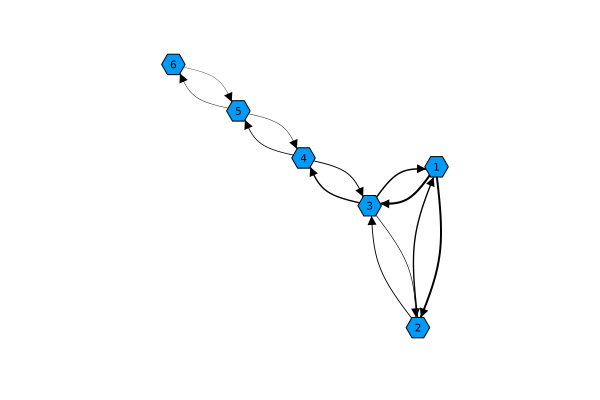

In [14]:
graphplot(visitMatrix,names=[1,2,3,4,5,6],edgewidth=edge_weights_func,arrow=arrow(:closed, :head, 1, 1), shorten=0.023, nodesize = 0.2)

##### 2.
Nodes size is proportional to the number of "next" or "back" clicks after watching the corresponding page

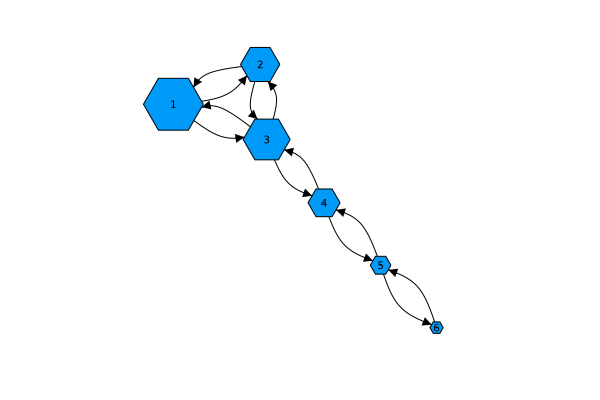

In [15]:
graphplot(visitMatrix,names=[1,2,3,4,5,6],node_weights=map(vert_edge_weights_func,visitVector),arrow=arrow(:closed, :head, 1, 1), nodesize = 0.3)